**Note**; This notebook might take some time to run since it uses the entire data downloaded for BRON. (There is a tutorial that deals with only a subset of the data in `bron_tutorial`)

# Set working directory

In [1]:
import os
cwd = os.path.split(os.getcwd())
if cwd[-1] == 'tutorials':
    os.chdir('..')
!python --version

Python 3.8.2


# Import modules

In [2]:
import json

from BRON.build_BRON import build_graph, BRON_PATH
from path_search.path_search_BRON import main_attack
from meta_analysis.make_data_summary import load_graph_network, main_data_summary
from utils.bron_network_utils import load_graph_nodes
from meta_analysis.meta_analysis_scripts.vendor_tactic_and_cvss import bron_id_to_cpe_id, cve_to_risk, make_heat_map
from utils.tutorial_util import print_files_in_folder

# Build BRON

In [3]:
# Path to save BRON output
save_path = 'full_data/full_output_data'
os.makedirs(save_path, exist_ok=True)
# Path to the downloaded threat information
input_data_folder = 'download_threat_information'
BRON_original_id_to_bron_id_path = os.path.join(save_path, BRON_PATH)
os.makedirs(BRON_original_id_to_bron_id_path, exist_ok=True)

In [4]:
build_graph(save_path, input_data_folder)

In [5]:
print_files_in_folder(BRON_original_id_to_bron_id_path)

('full_data/full_output_data/BRON/original_id_to_bron_id/tactic_name_to_bron_id.json '
 '1601407537.7683444')
('full_data/full_output_data/BRON/original_id_to_bron_id/technique_id_to_bron_id.json '
 '1601407537.7735841')
('full_data/full_output_data/BRON/original_id_to_bron_id/capec_id_to_bron_id.json '
 '1601407537.7890787')
('full_data/full_output_data/BRON/original_id_to_bron_id/cwe_id_to_bron_id.json '
 '1601407573.9949815')
('full_data/full_output_data/BRON/original_id_to_bron_id/cve_id_bron_id.json '
 '1601407574.4136708')
('full_data/full_output_data/BRON/original_id_to_bron_id/cpe_id_bron_id.json '
 '1601407575.0895107')


# Structure of BRON

Each entry of threat data is a node in BRON that has 4 attributes. The node has a unique name in BRON of the form (threat data type)\_(unique 5 digit id) where the threat data type is either Tactic, Technique, CAPEC, CWE, CVE, or CPE.

There are 4 attributes for each node:
- Original_id: ID of threat data in MITRE/NIST if it exists
- Datatype: One of Tactic, Technique, CAPEC, CWE, CVE, or CPE
- Name: Name of threat data in MITRE/NIST if it exists
- Metadata: Any additional information that is contained in MITRE/NIST 

# Find paths in BRON

In [6]:
starting_point_type = 'tactic'
starting_point = f'example_data/example_input_data/starting_point_{starting_point_type}.csv'
results_file = os.path.join(save_path, f'search_result_{starting_point_type}.csv')
length = True
main_attack(BRON_folder_path=save_path,
            args_file=starting_point,
            results_name=results_file,
            arg_type=starting_point_type,
            length=length)

,tactic,technique,capec,cwe,cve,risk_score,cpe,attack,Node Type
0,{tactic_00066},96,15,15,2069,12457.65,10296,NaN,connected
1,{tactic_00023},35,14,4,6500,31453.15,29398,NaN,connected
2,{tactic_00021},137,21,35,17125,100254.60,70854,NaN,connected
3,12,568,581,370,150545,904138.95,219054,0.0,Total Number


In [7]:
length = False
main_attack(BRON_folder_path=save_path,
            args_file=starting_point,
            results_name=results_file,
            arg_type=starting_point_type,
            length=length)

,tactic,technique,capec,cwe,cve,risk_score,cpe,attack,Node Type
0,{tactic_00066},"{technique_00564, technique_00079, technique_0...","{capec_00615, capec_00651, capec_00611, capec_...","{cwe_00828, cwe_01100, cwe_00770, cwe_00832, c...","{cve_353689, cve_259276, cve_339585, cve_23999...",12457.65,"{cpe_293494, cpe_212068, cpe_262325, cpe_16695...",NaN,connected
1,{tactic_00023},"{technique_00030, technique_00034, technique_0...","{capec_00642, capec_00600, capec_00597, capec_...","{cwe_00654, cwe_00730, cwe_01311, cwe_00825}","{cve_237549, cve_232736, cve_346362, cve_18680...",31453.15,"{cpe_354907, cpe_212068, cpe_160522, cpe_88567...",NaN,connected
2,{tactic_00021},"{technique_00053, technique_00256, technique_0...","{capec_00594, capec_00651, capec_00648, capec_...","{cwe_00654, cwe_00826, cwe_01424, cwe_00828, c...","{cve_114434, cve_79188, cve_237549, cve_189374...",100254.60,"{cpe_354907, cpe_212068, cpe_160522, cpe_14678...",NaN,connected
3,12,568,581,370,150545,904138.95,219054,0.0,Total Number


In [8]:
starting_point_type = 'technique'
starting_point = f'example_data/example_input_data/starting_point_{starting_point_type}.csv'
results_file = os.path.join(save_path, f'search_result_{starting_point_type}.csv')
length = False
main_attack(BRON_folder_path=save_path,
            args_file=starting_point,
            results_name=results_file,
            arg_type=starting_point_type,
            length=length)

,tactic,technique,capec,cwe,cve,risk_score,cpe,attack,Node Type
0,{},{technique_00006},{},{},{},0.00,{},NaN,connected
1,12,568,581,370,150545,904138.95,219054,0.0,Total Number


In [9]:
# Path to BRON data
BRON_path = os.path.join(save_path, 'BRON.json')
save_folder = os.path.join(save_path, 'all_cves_all_versions')
os.makedirs(save_folder, exist_ok=True)
not_all_cpe_versions = False
# Load the BRON graph
graph = load_graph_network(BRON_path, not_all_cpe_versions)

datatypes = ["tactic", "technique", "capec", "cwe", "cve", "cpe"]
# Summarize data sources in BRON
main_data_summary(graph=graph,
                  save_folder=save_folder,
                  data_types=datatypes)

tactic
technique
capec
cwe
cve
cpe


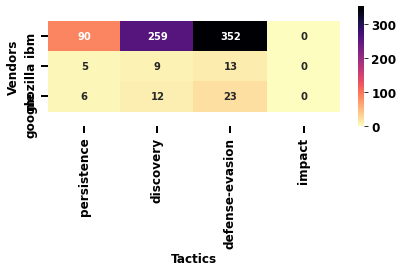

In [10]:
tactics = 'persistence,discovery,defense-evasion,impact'
vendors = 'ibm,mozilla,google'
tactic_search_result_file = os.path.join(save_path, 'search_result_tactic.csv')
plot_type = 'heatmap'
cve_summary_path = os.path.join(save_folder, 'cve_summary.csv')
_save_path = os.path.join(save_path, 'figures')
_figure_path = os.path.join(save_path, 'vendor_tactics.png')
tactics_split = tactics.split(',')
vendors_split = vendors.split(',')
bron_id_to_cpe_id_dict = bron_id_to_cpe_id(save_path)
cve_to_risk_dict = cve_to_risk(cve_summary_path)
with open(os.path.join(BRON_original_id_to_bron_id_path, 'tactic_name_to_bron_id.json'), 'r') as fd:
    all_tactics_name_to_id = json.load(fd)
tactic_ids = [f"tactic_{all_tactics_name_to_id[_]}" for _ in tactics_split]

make_heat_map(tactics_split,
              vendors_split,
              tactic_ids,
              tactic_search_result_file,
              bron_id_to_cpe_id_dict,
              save_path=_figure_path)